In [2]:
import numpy as np


### parameters to get extinction coeff for NPA at give pH value
pH = 7.0
e_NPA = 18300  ### extinction coeff for NPA anion
pKa_NPA = 7.15 ### pKa for p-nitrophenol

### List of kcat values for the enzyme in each lane (s^-1)
kcat_list = [100] * 12
kcat_list = np.array(kcat_list)
kcat_list = kcat_list * 60    ### convert from s^-1 to min^-1

### List of KM values for the enzyme in each lane (mM)
### Note: Values must not be zero. For no enzyme, use zero concentration in next list
KM_list = [0.05] * 12
KM_list = np.array(KM_list)
KM_list = KM_list * 1E-3       ### convert from mM to M

### List of the enzyme concentrations in each lane (nanomolar)
Max_E_conc = 1   ### nanomolar
E_conc_list = [0, 0, 0, 1, 1, 1, 1/2, 1/2, 1/2, 1/4, 1/4, 1/4]
E_conc_list = np.array(E_conc_list)  * Max_E_conc
E_conc_list = E_conc_list * 1E-9 * 2 ### convert from nM to M

### List of Lane Names
lane_name_list = ["1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12"]

### List of Row Names
row_name_list = ["A", "B", "C", "D", "E", "F", "G", "H"]

### List of the NPA conc in the eight wells of each lane (mM)
S_conc_list = [0.01, 0.02, 0.03, 0.04, 0.06, 0.1, 0.25, 0.5]
S_conc_list = np.array(S_conc_list)
S_conc_list = S_conc_list * 1E-3       ### convert from mM to M

### Calculated Values from the above lists
Vmax_list = kcat_list * E_conc_list   ### Vmax from kcat and [E]

Ka = 10 ** -pKa_NPA   ### extinction coeff for NPA at given pH
H = 10 ** -pH
e_NPA = e_NPA * (Ka / (H + Ka))


In [3]:
### This creates the data set separate x,y data files names as lane,row

data_name = "data1/data"
data_file_extention = ".csv"

#!wget https://raw.githubusercontent.com/blinkletter/StealThisCode/main/BiochemToolbox.py
#!pip install uncertainties  # to install 'Uncertainties' package in Colab. 
import BiochemToolbox as BT

import numpy as np
import pandas as pd

eq, f = BT.get_integrated_MM_function()

time_start = 0.5
time_end = 60           ### The end time
n_points = 360          ### number of points - increase if needed

voltage_error = 0.001   ### parameters to define output range and error
random_error = 0.001
max_value = 4

dt = time_end / n_points          ### time step, delta t
t_line = np.arange(time_start,    ### time vector (list of time points)
                   time_end + dt, 
                   dt) 

### Note: Lane names, enzyme conc list, KM list and Vmax list must all be
### same length or this will fail. Row names and row concentration lists 
### must also have equal lengths.

parameters = zip(lane_name_list, Vmax_list, KM_list)
for p in parameters:
    lane_name, Vmax_value, KM_value = p   ### unpack kcat, KM and [E]
    #print(lane_name)

    row_info = zip(row_name_list, S_conc_list)
    for row in row_info:
        row_name, S0_value = row      ### unpack row name and substrate conc
        plate_df = pd.DataFrame([])   ### start with empty dataframe
        #print(row_name)

        ### Calculate product from enzyme reaction 
        product_E = S0_value - f(t_line, S0_value, KM_value, Vmax_value)   
        product_E = np.real(product_E)  ### complex numbers fixed

        ### Calculate product from uncatalyzed reaction 
        product_NPA = S0_value - S0_value * np.exp(-1E-3 * t_line)
        product = product_E + product_NPA
        absorbance = product * e_NPA   ### result in absorbance units

        ### Add voltage error 
        fraction_transmittance  = 1 / (10 ** absorbance)                      
        fraction_transmittance = np.random.normal(fraction_transmittance, 
                                                  voltage_error, 
                                                  len(fraction_transmittance))
        absorbance = -np.log10(fraction_transmittance)

        ### Add random error
        absorbance = np.random.normal(absorbance,     
                                      random_error, 
                                      len(absorbance))   

        absorbance[absorbance > max_value] = max_value   ### cap values 
        absorbance = np.nan_to_num(absorbance,  ### replace NaN with max value
                          copy = True, 
                          nan = max_value)   

        ### insert the two data arrays into the dataframe
        plate_df["time"] = t_line
        plate_df["abs"] = absorbance

        ### Write data out to file using lane_name and row_name
        out_file_name = data_name + "_" + lane_name + "_" \
            + row_name + data_file_extention
        plate_df.to_csv(out_file_name)



/var/folders/3h/d_p2gtjd78g8c7m6c14chsg00000gq/T/ipykernel_94334/1259405424.py:57: RuntimeWarning: invalid value encountered in log10
  absorbance = -np.log10(fraction_transmittance)
/var/folders/3h/d_p2gtjd78g8c7m6c14chsg00000gq/T/ipykernel_94334/1259405424.py:57: RuntimeWarning: invalid value encountered in log10
  absorbance = -np.log10(fraction_transmittance)
/var/folders/3h/d_p2gtjd78g8c7m6c14chsg00000gq/T/ipykernel_94334/1259405424.py:57: RuntimeWarning: invalid value encountered in log10
  absorbance = -np.log10(fraction_transmittance)


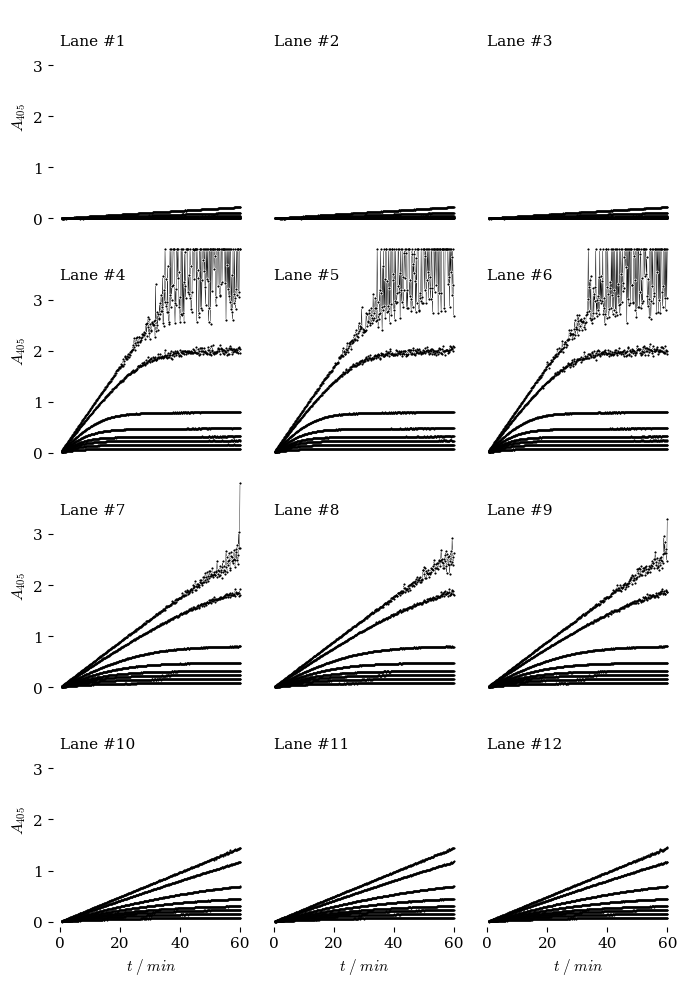

In [5]:
### Contact sheet. Ticks deleted on plots inside the set.


from matplotlib import pyplot as plt

plt.ioff()      ### switch off interactive display of plots. plt.show() needed to display a plot now
plt.rcdefaults()     ### resets the plot defaults so we always start in the same place
plt.style.use("../styles/tufte.mplstyle")     ### Then add a fancy style sheet   

fig, ax = plt.subplots(nrows=4, 
                       ncols=3, 
                       figsize=(7,10), 
                    #   sharex=True, 
                    #   sharey=True
                       )  

data_name = "data1/data"
data_file_extention = ".csv"

n = 0

for lane_name in lane_name_list:
    
    plot_row = n // 3
    plot_col = n % 3

    ax[plot_row][plot_col].set(
                xlabel= None, 
                ylabel=None,
        #        title = "Lane # "+lane_name,
        #        xlim=[None, None],                  
                ylim=[-.1, 4.1]      
               )
    ax[plot_row][0].set(ylabel= r"$A_{405}$")
    ax[plot_row][0].set_yticks([0,1,2,3])
    ax[plot_row][1].set_yticks([])
    ax[plot_row][2].set_yticks([])

    ax[3][plot_col].set(xlabel= r"$t\;/\;min$")
    ax[0][plot_col].set_xticks([])
    ax[1][plot_col].set_xticks([])
    ax[2][plot_col].set_xticks([])

    ax[plot_row][plot_col].text(0, 3.4, "Lane #"+lane_name) 

    for row_name in row_name_list:
        in_file_name = data_name + "_" + lane_name + "_" \
             + row_name + data_file_extention

        df = pd.read_csv(in_file_name)

        x = df["time"] 
        y = df["abs"] 
        ax[plot_row][plot_col].plot(x, y, 
                                    linestyle = '-', 
                                    linewidth='0.3', 
                                    color = 'black', 
                                    zorder = 0)
        ax[plot_row][plot_col].scatter(x, y, 
                                       marker='o', 
                                       color='black', 
                                       edgecolors = None,
                                       linewidths = 0.5, 
                                       s=1, 
                                       zorder = 2)
        ax[plot_row][plot_col].scatter(x, y, 
                                       marker='o', 
                                       color='white', 
                                       edgecolors = None,
                                       linewidths = 0.5, 
                                       s=4, 
                                       zorder = 1)

    n += 1

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.savefig("plotA.pdf")     ### export the plot as this
#plt.show()                 ### display the plot in this notebook


In [110]:
### Contact sheet using shared axes. Ticks will be on each plot.

from matplotlib import pyplot as plt

plt.ioff()      ### switch off interactive display of plots. plt.show() needed to display a plot now
plt.rcdefaults()     ### resets the plot defaults so we always start in the same place
plt.style.use("../styles/tufte.mplstyle")     ### Then add a fancy style sheet   

fig, ax = plt.subplots(nrows=4, 
                       ncols=3, 
                       figsize=(7,10), 
                       sharex=True, 
                       sharey=True
                       )  

data_name = "data1/data"
data_file_extention = ".csv"

n = 0

for lane_name in lane_name_list:
    
    plot_row = n // 3
    plot_col = n % 3

    ax[plot_row][plot_col].set(
                xlabel= None, 
                ylabel=None,
            #    title = "Lane # "+lane_name,
            #    xlim=[None, None],                  
                ylim=[-.1, 4.1]      
               )
    ax[plot_row][0].set(ylabel= r"$A_{405}$")

    ax[3][plot_col].set(xlabel= r"$t\;/\;min$")

    ax[plot_row][plot_col].set_yticks([0,1,2,3])
    ax[plot_row][plot_col].text(0, 3.4, "Lane #"+lane_name) 

    for row_name in row_name_list:
        in_file_name = data_name + "_" + lane_name + "_" \
             + row_name + data_file_extention

        df = pd.read_csv(in_file_name)

        x = df["time"] 
        y = df["abs"] 
        ax[plot_row][plot_col].plot(x, y, 
                                    linestyle = '-', 
                                    linewidth='0.3', 
                                    color = 'black', 
                                    zorder = 0)
        ax[plot_row][plot_col].scatter(x, y, 
                                       marker='o', 
                                       color='black', 
                                       edgecolors = None,
                                       linewidths = 0.5, 
                                       s=1, 
                                       zorder = 2)
        ax[plot_row][plot_col].scatter(x, y, 
                                       marker='o', 
                                       color='white', 
                                       edgecolors = None,
                                       linewidths = 0.5, 
                                       s=4, 
                                       zorder = 1)

    n += 1

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.savefig("plot.pdf")     ### export the plot as this
#plt.show()                 ### display the plot in this notebook


In [8]:
import numpy as np

8.314*298*np.log(5/20) + (+1)*96500*(-0.02)

-5364.64409286853

In [10]:
8.314*298*np.log(390/3) + (+2)*96500*(-0.02)

8199.667063484138

In [23]:
-26000 + 8.314*298*np.log((2.9*1) / (0.0015*0.051))

120.8695388426313